In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization


In [54]:
X = pd.read_csv("train (6).csv")
y = pd.read_csv('train_churn_labels.csv')
print(X.shape)
print(X.head())
print(y.value_counts())

(50000, 230)
   Var1  Var2  Var3  Var4  Var5    Var6  Var7  Var8  Var9  Var10  ...  \
0   NaN   NaN   NaN   NaN   NaN  1526.0   7.0   NaN   NaN    NaN  ...   
1   NaN   NaN   NaN   NaN   NaN   525.0   0.0   NaN   NaN    NaN  ...   
2   NaN   NaN   NaN   NaN   NaN  5236.0   7.0   NaN   NaN    NaN  ...   
3   NaN   NaN   NaN   NaN   NaN     NaN   0.0   NaN   NaN    NaN  ...   
4   NaN   NaN   NaN   NaN   NaN  1029.0   7.0   NaN   NaN    NaN  ...   

    Var221   Var222      Var223  Var224  Var225  Var226   Var227  \
0     oslk  fXVEsaq  jySVZNlOJy     NaN     NaN    xb3V     RAYp   
1     oslk  2Kb5FSF  LM8l689qOp     NaN     NaN    fKCe     RAYp   
2  Al6ZaUT  NKv4yOc  jySVZNlOJy     NaN    kG3k    Qu4f  02N6s8f   
3     oslk  CE7uk3u  LM8l689qOp     NaN     NaN    FSa2     RAYp   
4     oslk  1J2cvxe  LM8l689qOp     NaN    kG3k    FSa2     RAYp   

          Var228  Var229  Var230  
0  F2FyR07IdsN7I     NaN     NaN  
1  F2FyR07IdsN7I     NaN     NaN  
2  ib5G6X1eUxUn6    am7c     NaN  

### EDA

In [55]:
missing_ratio = X.isnull().mean().sort_values(ascending=False)
high_missing_cols = missing_ratio[missing_ratio > 0.90].index
X.drop(columns=high_missing_cols, inplace=True)


# len(high_missing_cols)
print(high_missing_cols)



Index(['Var230', 'Var175', 'Var55', 'Var32', 'Var141', 'Var20', 'Var39',
       'Var42', 'Var167', 'Var79',
       ...
       'Var145', 'Var164', 'Var138', 'Var4', 'Var135', 'Var106', 'Var124',
       'Var82', 'Var99', 'Var51'],
      dtype='object', length=154)


In [56]:
len(high_missing_cols)/230

0.6695652173913044

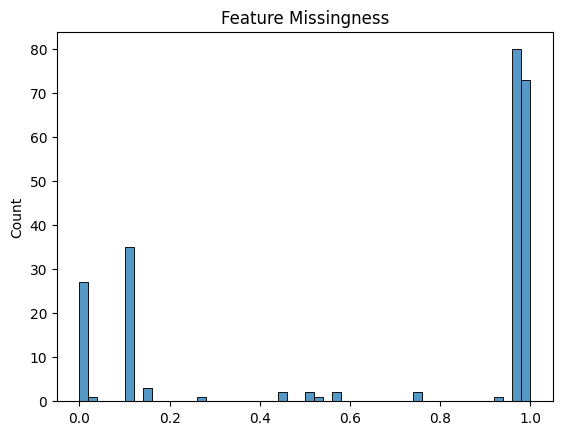

/var/folders/sv/2cnfp66152jb0hq74_5q4cvm0000gn/T/ipykernel_61167/1220095633.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_ratio.head(200), y=missing_ratio.head(200).index, palette='mako')


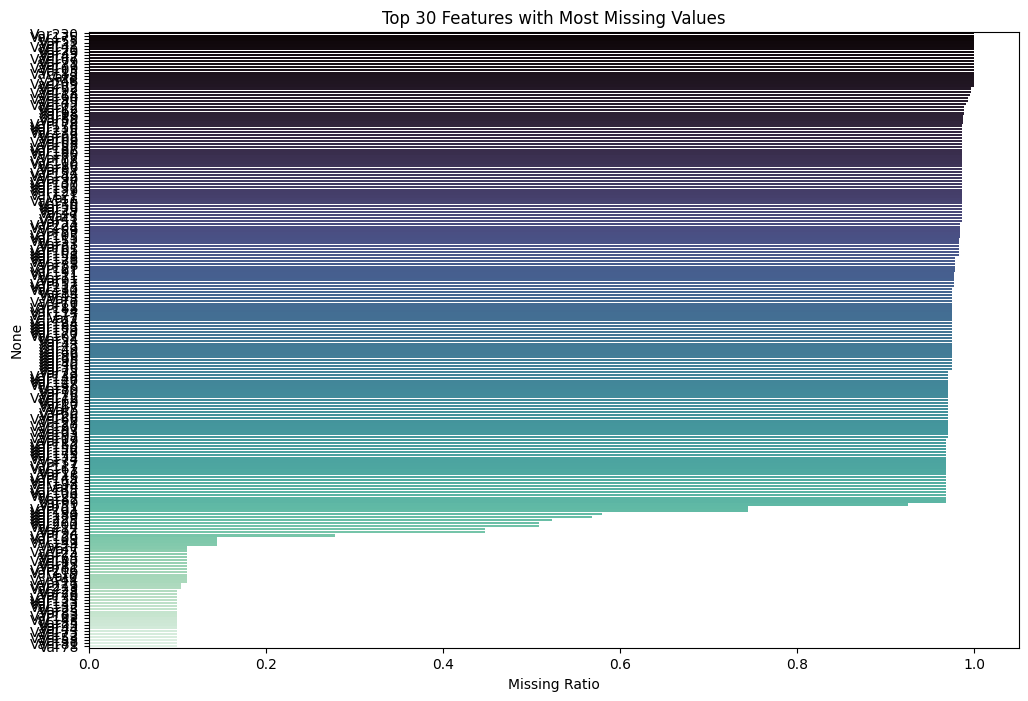

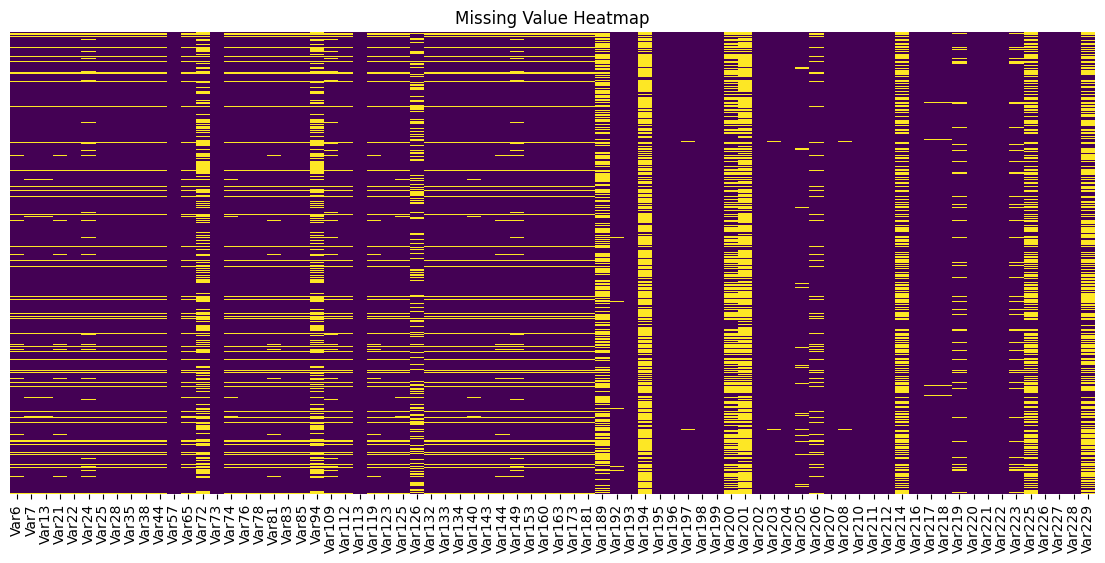

In [4]:
# Visualize missing data
sns.histplot(missing_ratio, bins=50)
plt.title("Feature Missingness")
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x=missing_ratio.head(200), y=missing_ratio.head(200).index, palette='mako')
plt.xlabel("Missing Ratio")
plt.title("Top 30 Features with Most Missing Values")
plt.show()

plt.figure(figsize=(14, 6))
sns.heatmap(X.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Missing Value Heatmap")
plt.show()

/var/folders/sv/2cnfp66152jb0hq74_5q4cvm0000gn/T/ipykernel_61167/748067477.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=missing_df, x='dtype', y='missing_ratio', palette='Set2')


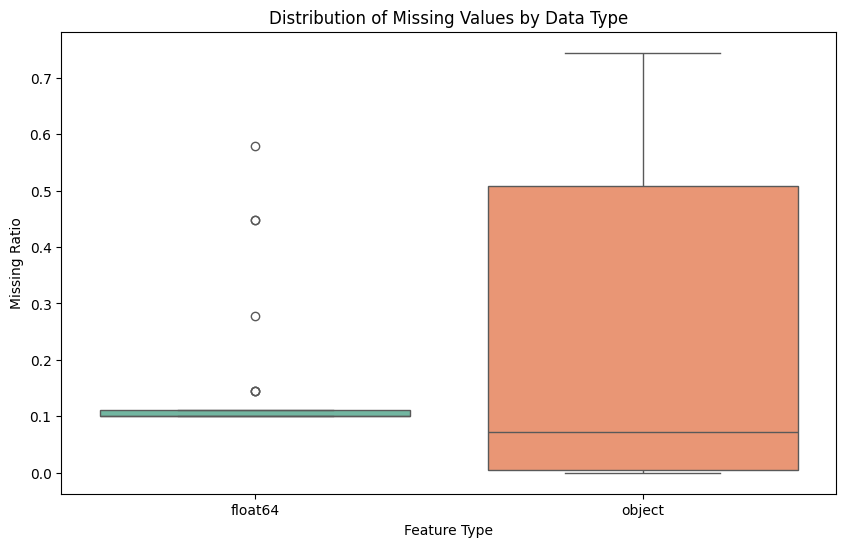

In [5]:
missing_df = pd.DataFrame({'missing_ratio': X.isnull().mean(), 'dtype': X.dtypes})
missing_df = missing_df[missing_df['missing_ratio'] > 0]

plt.figure(figsize=(10, 6))
sns.boxplot(data=missing_df, x='dtype', y='missing_ratio', palette='Set2')
plt.title("Distribution of Missing Values by Data Type")
plt.ylabel("Missing Ratio")
plt.xlabel("Feature Type")
plt.show()

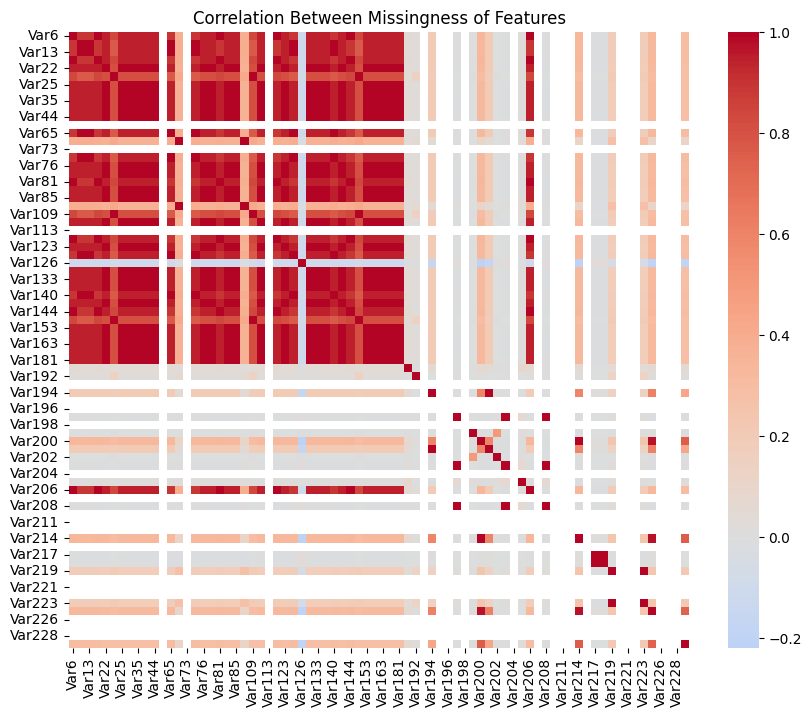

In [6]:
# Compute a correlation heatmap of missing indicators
missing_indicator = X.isnull().astype(int)
corr = missing_indicator.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Between Missingness of Features")
plt.show()

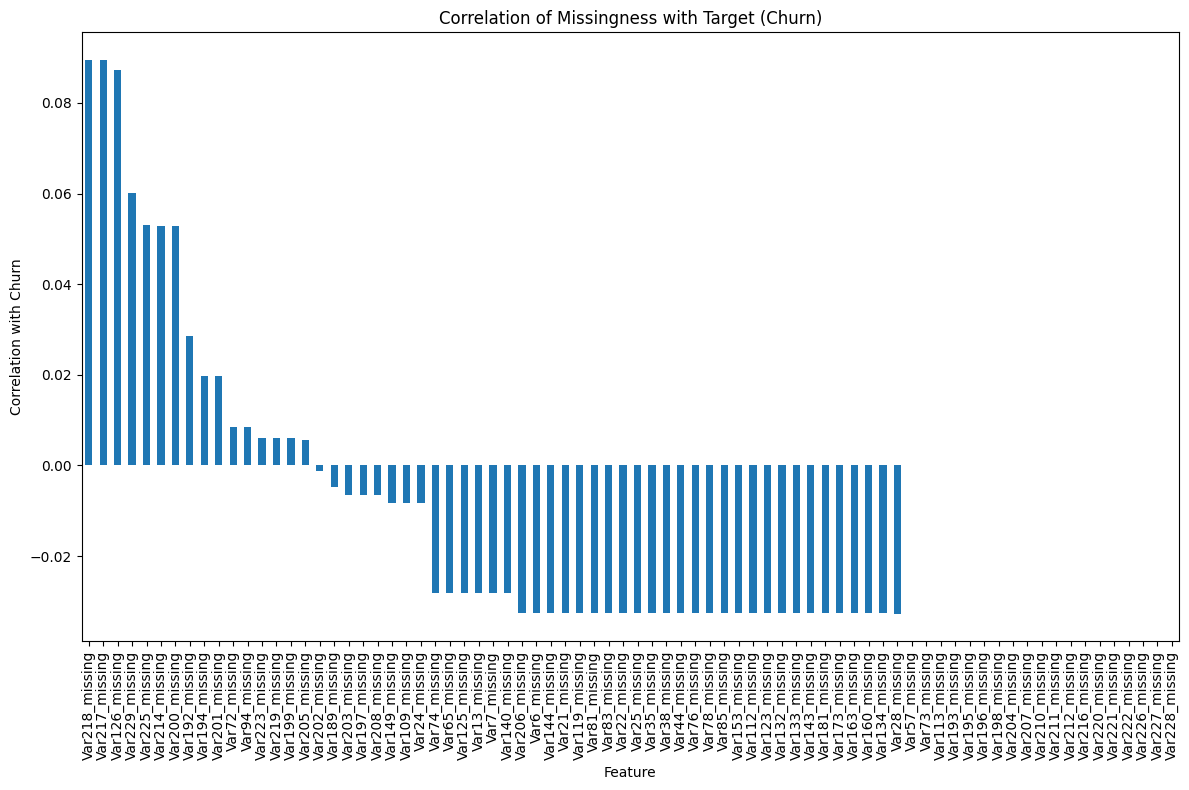

In [7]:
X_temp = X.copy()
X_temp['target'] = y  # assuming y is the label series

# Create indicators
for col in X.columns:
    X_temp[col + '_missing'] = X_temp[col].isnull().astype(int)

missing_vs_target = X_temp[[col for col in X_temp.columns if '_missing' in col] + ['target']]

# Correlate missingness with churn
correlations = missing_vs_target.corr()['target'].drop('target').sort_values(ascending=False)

plt.figure(figsize=(12, 8))
correlations.plot(kind='bar')
plt.title("Correlation of Missingness with Target (Churn)")
plt.ylabel("Correlation with Churn")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

### Feature Engineering

In [57]:
numeric_cols = X.select_dtypes(include=[np.number]).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns


Numeric Summary:
           count          mean           std           min           25%  \
Var6    44471.0  1.326437e+03  2.685694e+03  0.000000e+00  5.180000e+02   
Var7    44461.0  6.809496e+00  6.326053e+00  0.000000e+00  0.000000e+00   
Var13   44461.0  1.249688e+03  2.794955e+03  0.000000e+00  0.000000e+00   
Var21   44471.0  2.345182e+02  5.655601e+02  0.000000e+00  1.120000e+02   
Var22   44991.0  2.902454e+02  7.044900e+02  0.000000e+00  1.350000e+02   
Var24   42770.0  4.507926e+00  9.928819e+00  0.000000e+00  0.000000e+00   
Var25   44991.0  9.682701e+01  2.143183e+02  0.000000e+00  1.600000e+01   
Var28   44989.0  2.245077e+02  9.852024e+01 -6.688000e+01  1.665600e+02   
Var35   44991.0  7.168100e-01  2.996007e+00  0.000000e+00  0.000000e+00   
Var38   44991.0  2.579107e+06  3.010076e+06  0.000000e+00  7.794000e+03   
Var44   44991.0  1.668334e-01  1.629344e+00  0.000000e+00  0.000000e+00   
Var57   50000.0  3.512311e+00  2.025882e+00  2.136296e-04  1.743164e+00   
Var65  

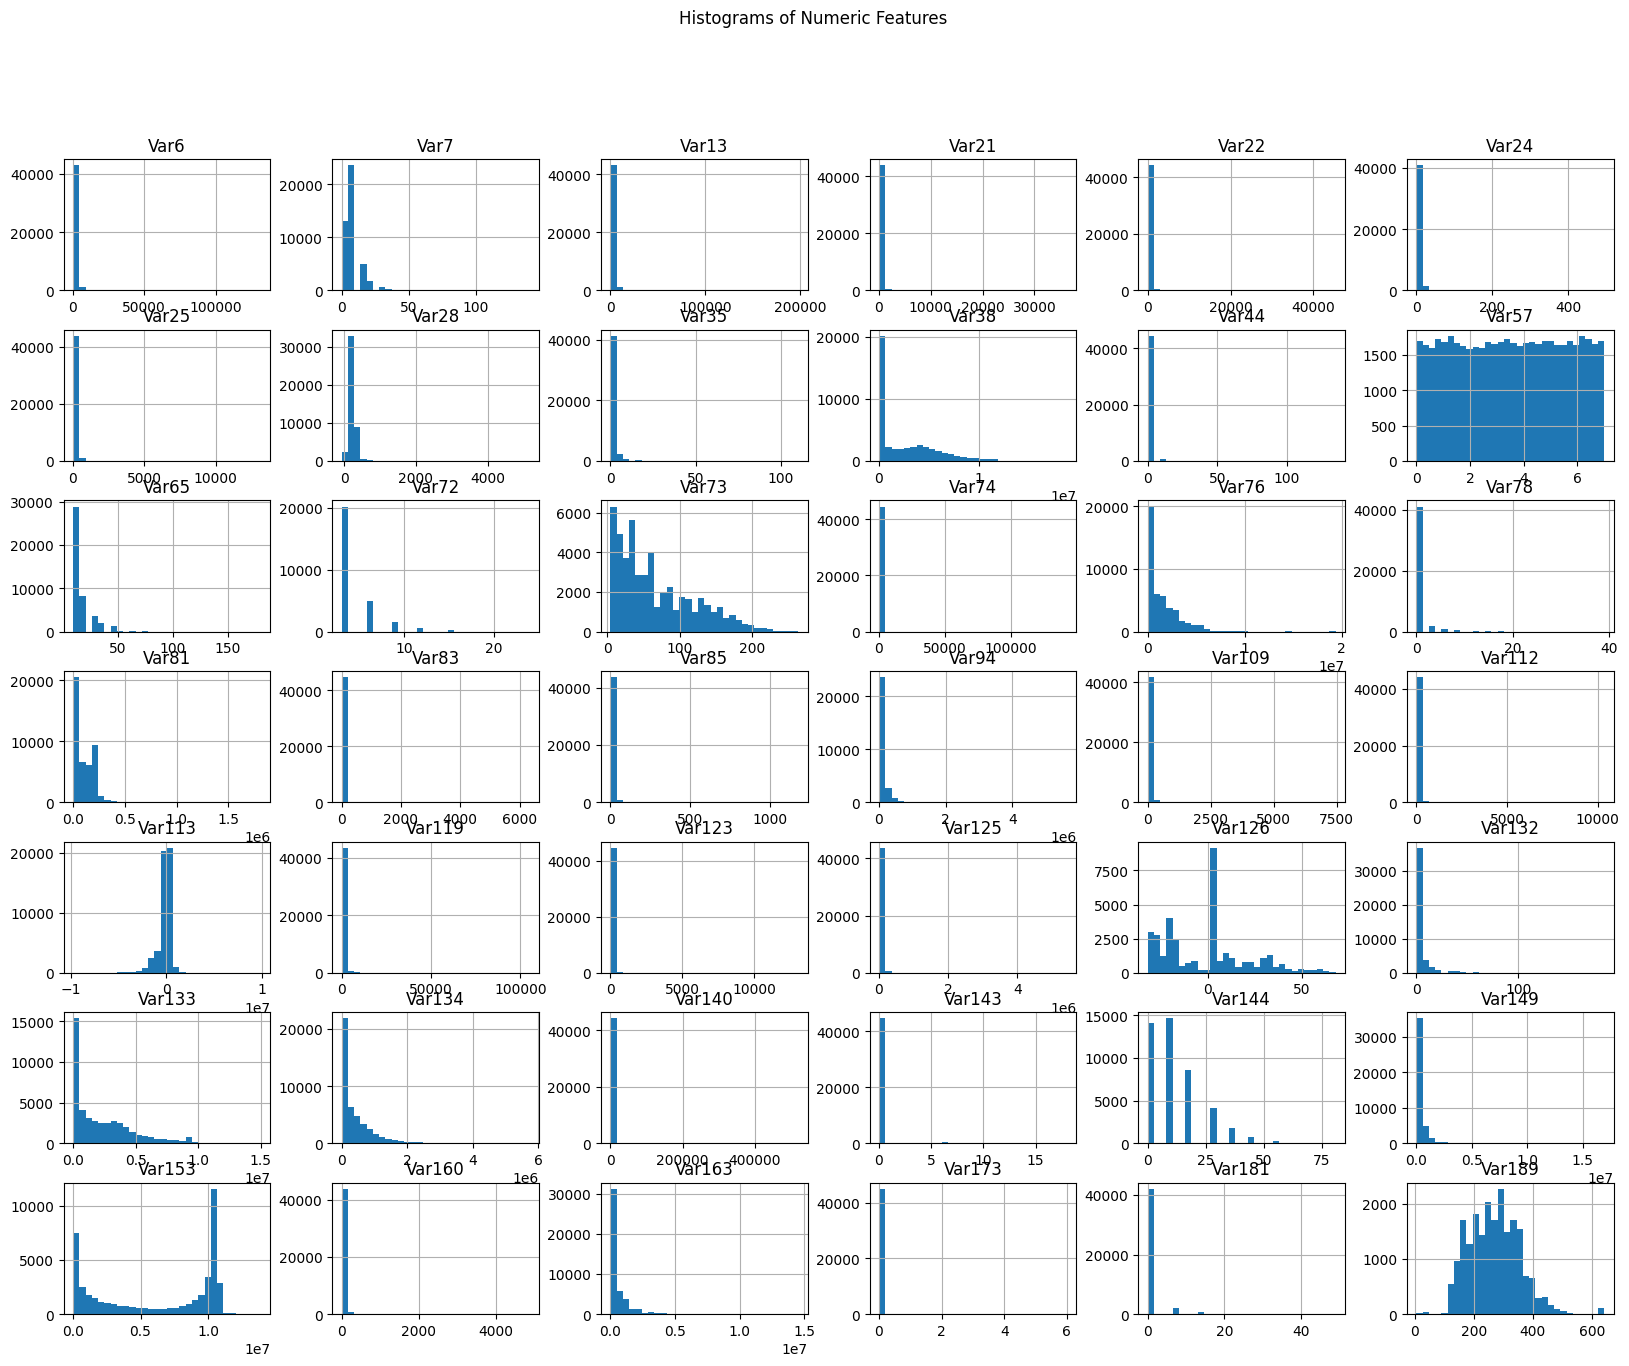


Var192 - Cardinality: 361
Var192
qFpmfo8zhV    385
DHeq9ayfAo    384
zKnr4RXktW    380
8I1r4RXXnK    379
HYTrjIK12c    379
75lr4RXktW    377
1GdOj1KXzC    376
2jirEyXktW    373
CxSr4RXktW    369
vAsgUHXM47    368
Name: count, dtype: int64

Var193 - Cardinality: 51
Var193
RO12                                  35964
2Knk1KF                                7271
AERks4l                                2243
g62hiBSaKg                              580
e6CkoqApVR                              524
LrdZy8QqgUfkVShG                        458
rEUOq2QD1qfkRr6qpua                     455
eSGpMwS8zSGgq_trOpckZ5                  444
onTuEhrJJQy_H3IHkZku5AFczhYGqxJ890      260
w9ygS99Qp_                              181
Name: count, dtype: int64

Var194 - Cardinality: 3
Var194
SEuy    12567
lvza      176
CTUH       41
Name: count, dtype: int64

Var195 - Cardinality: 23
Var195
taul                47958
LfvqpCtLOY            866
CiJDdr4TQ0rGERIS      544
ev6I                  179
CuXi4je               15

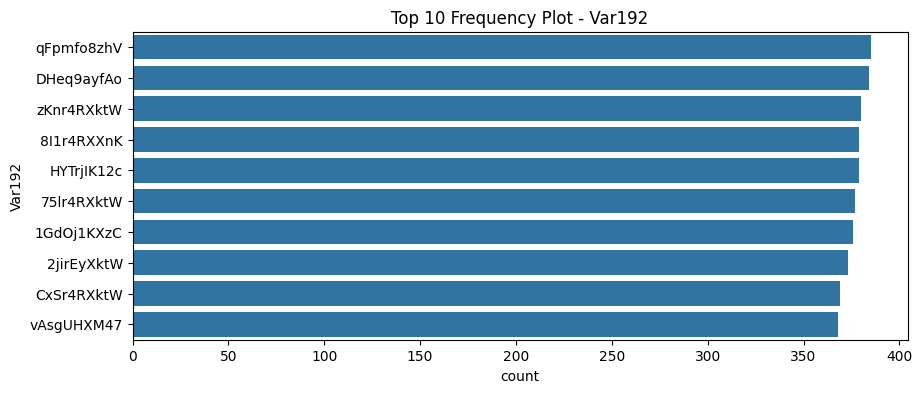

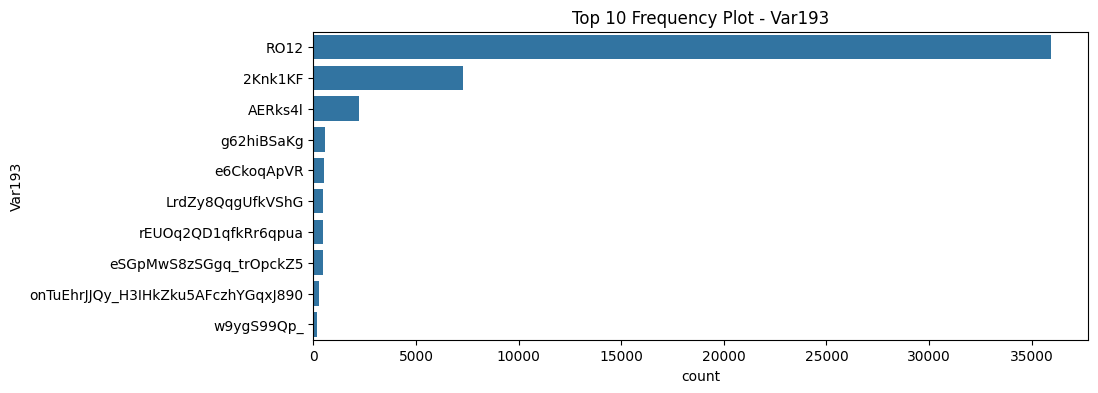

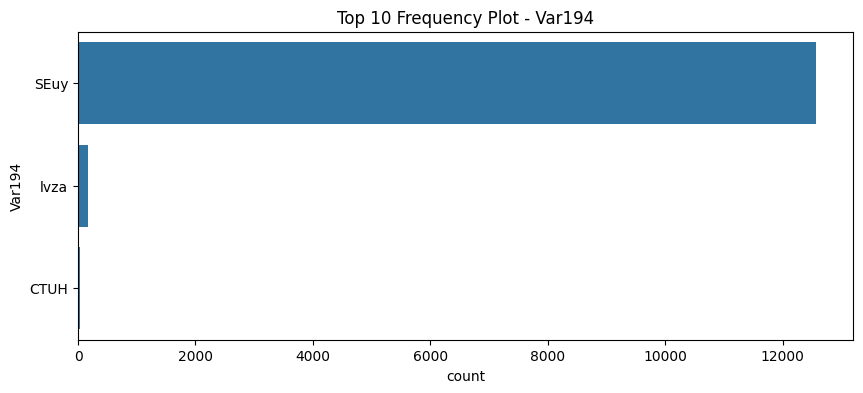

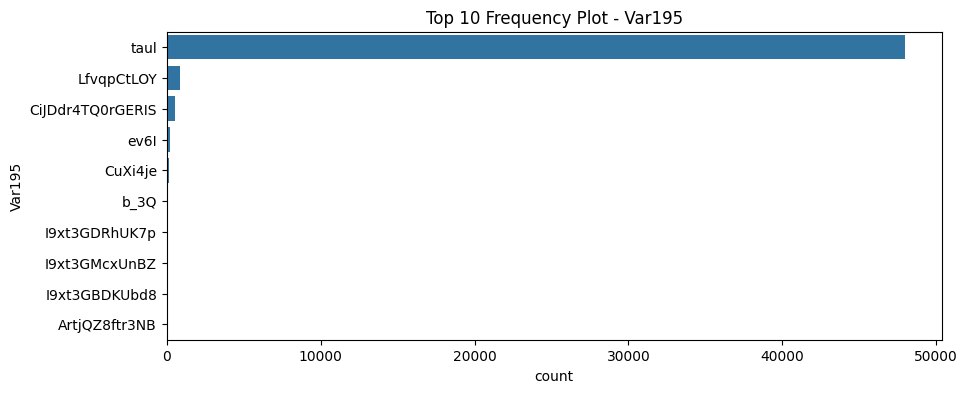

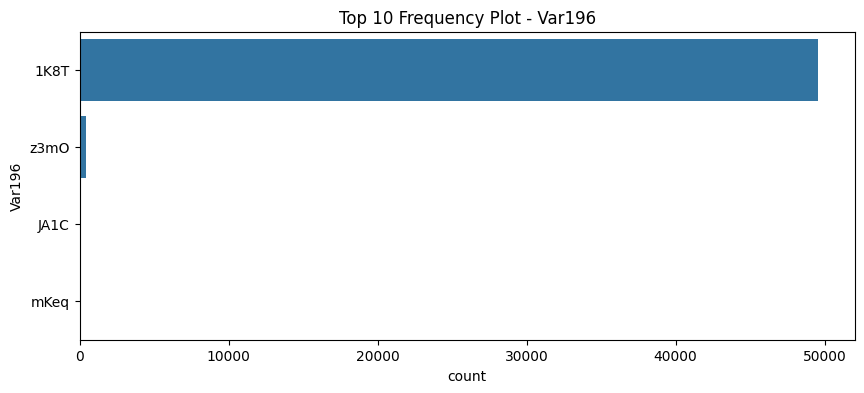

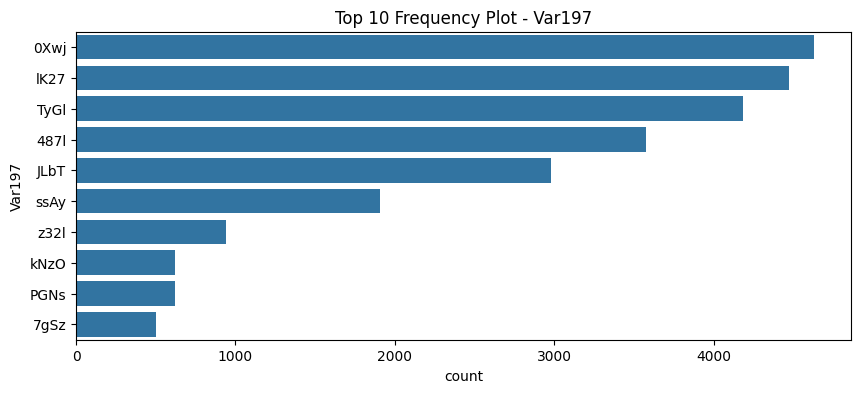

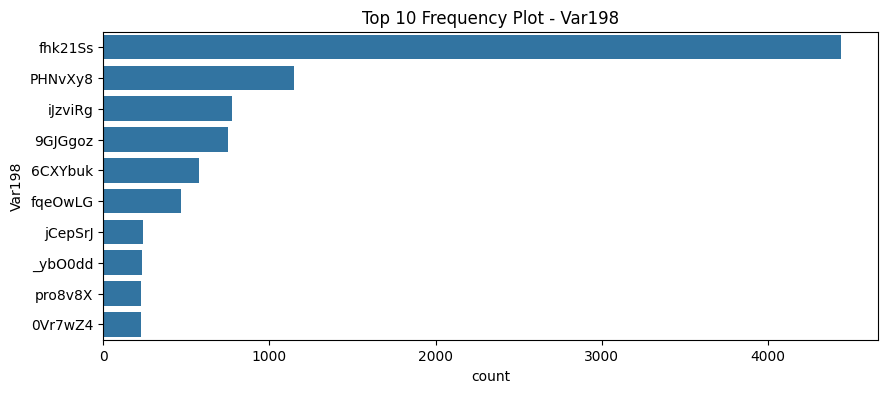

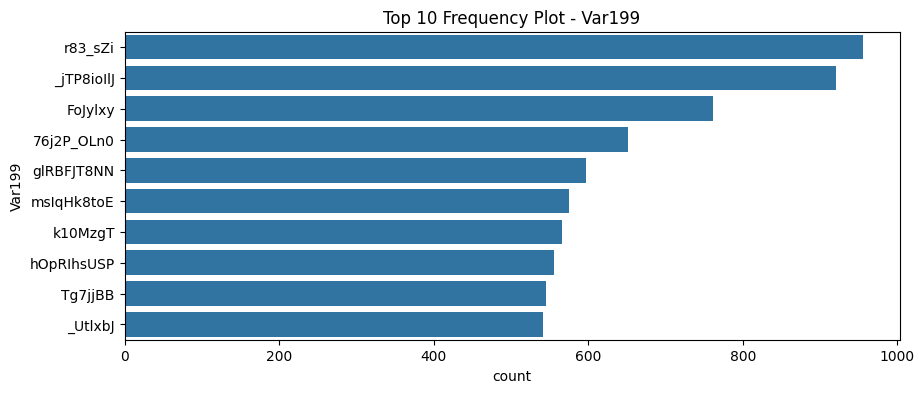

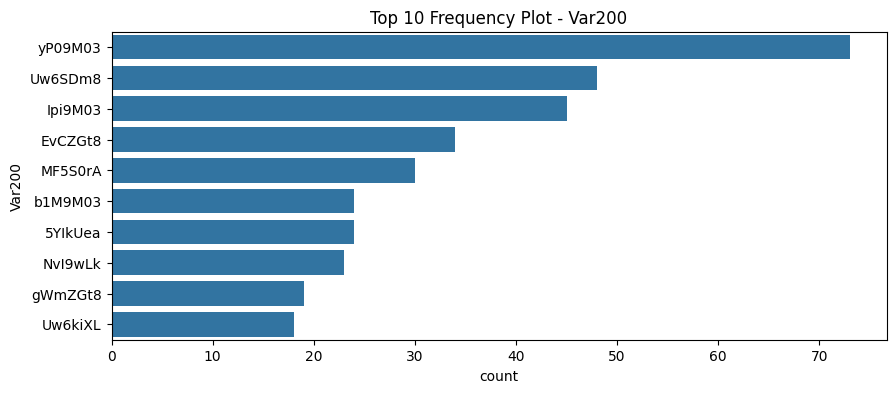

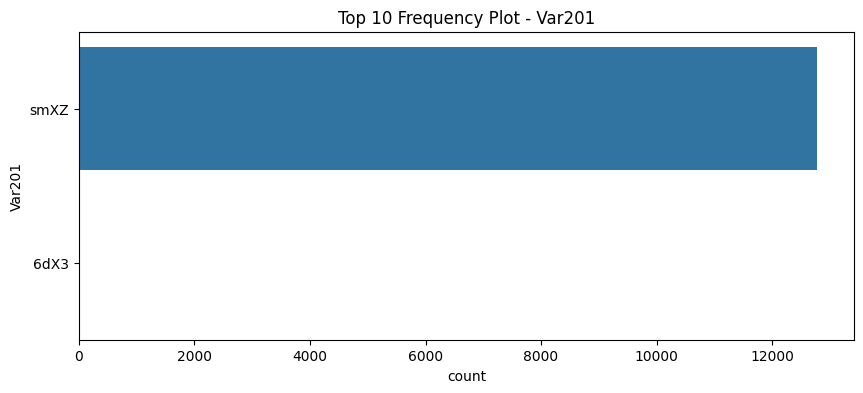

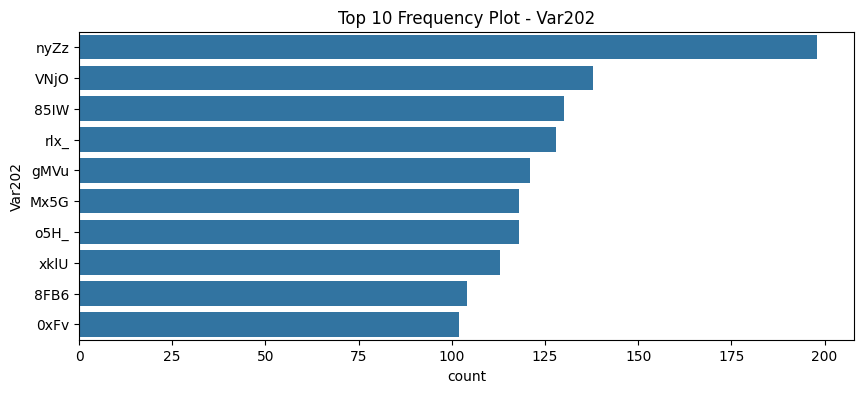

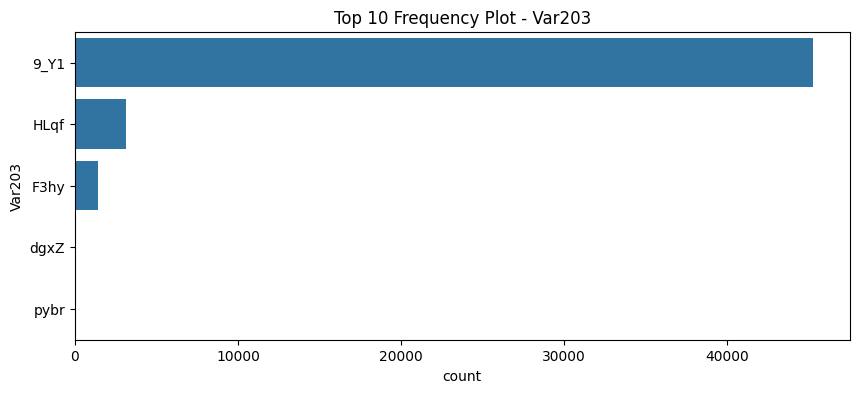

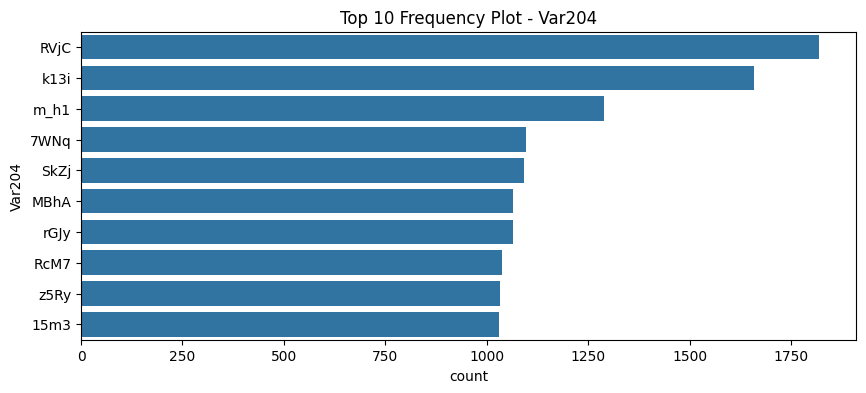

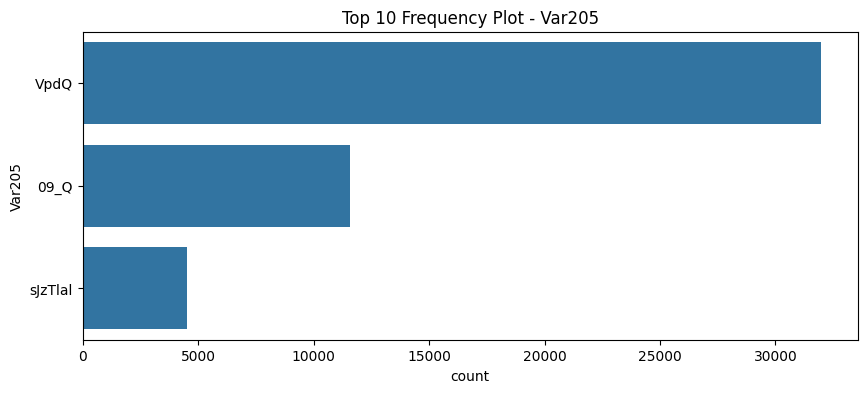

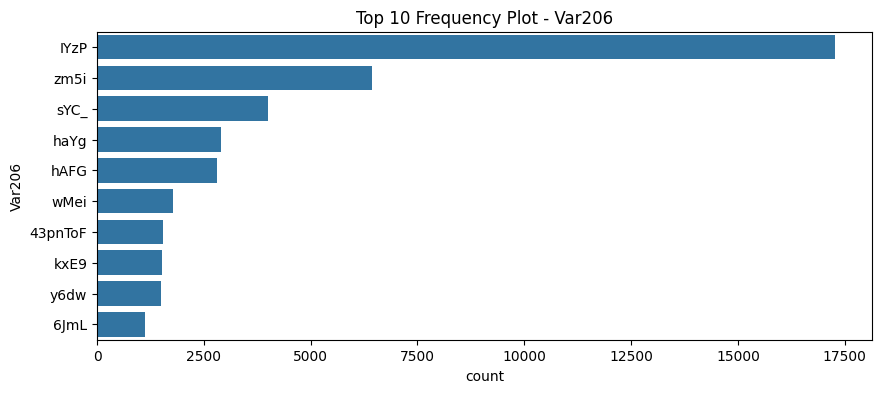

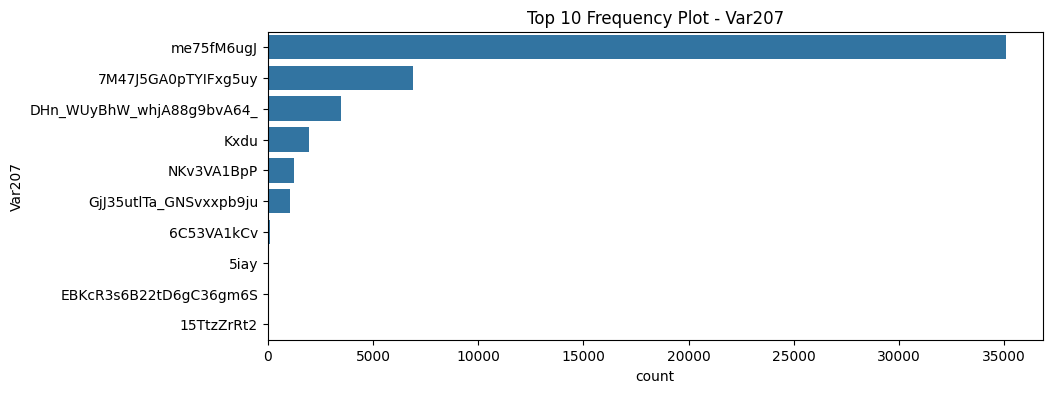

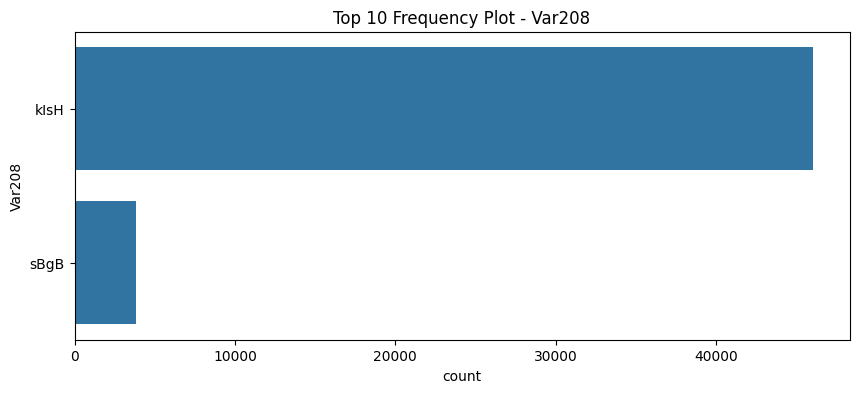

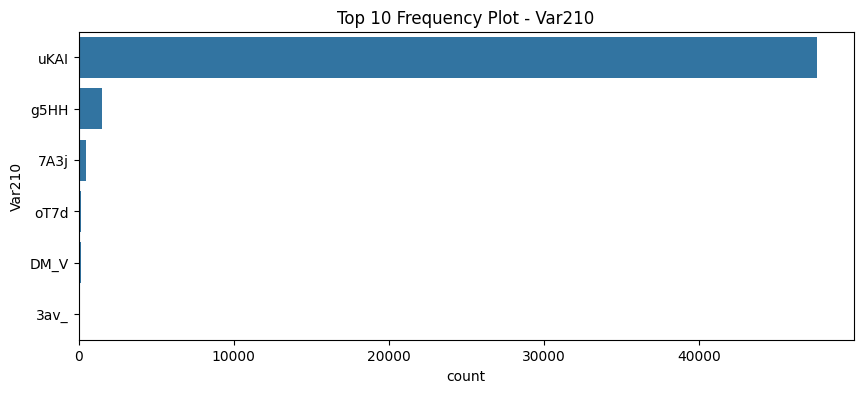

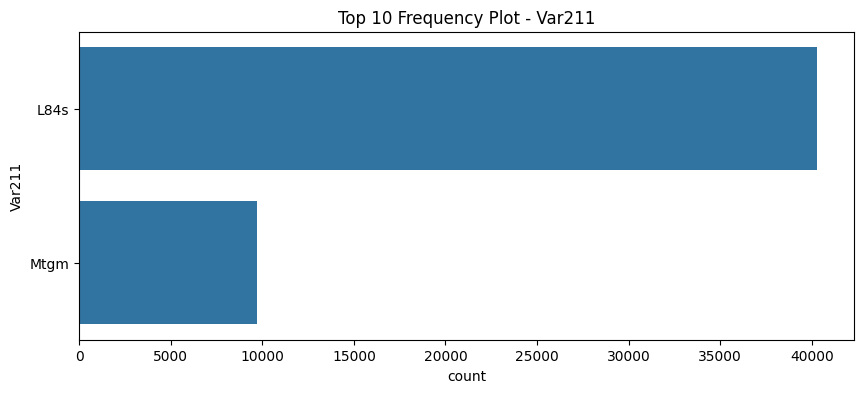

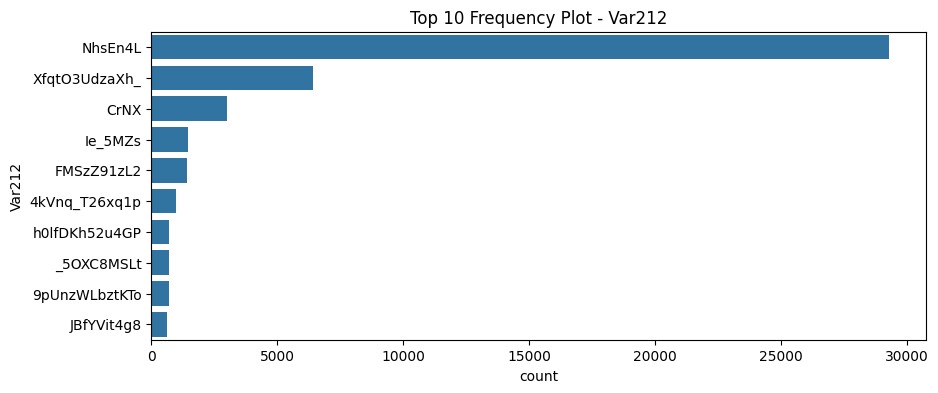

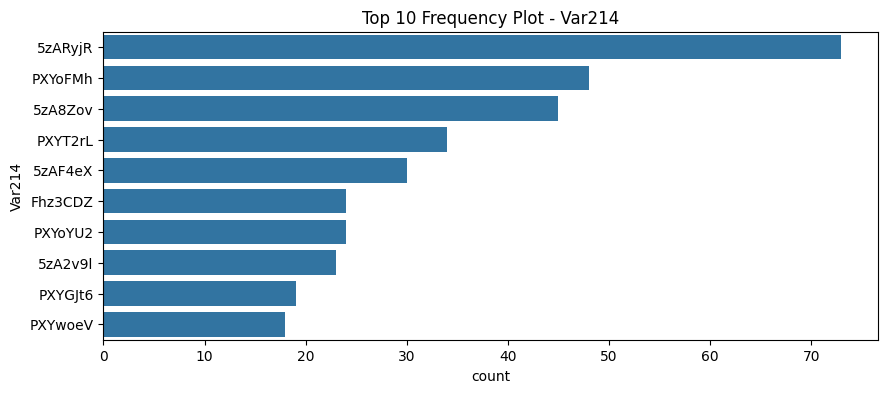

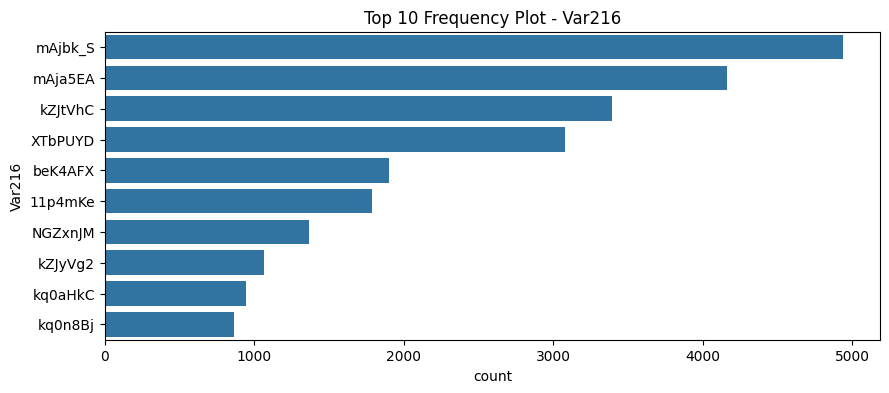

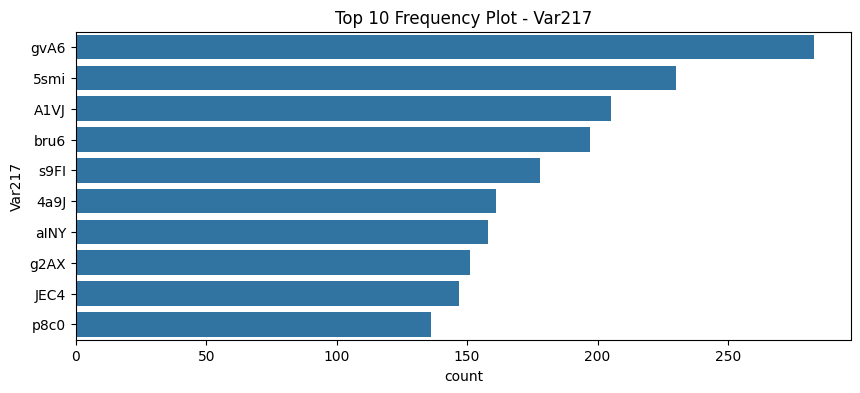

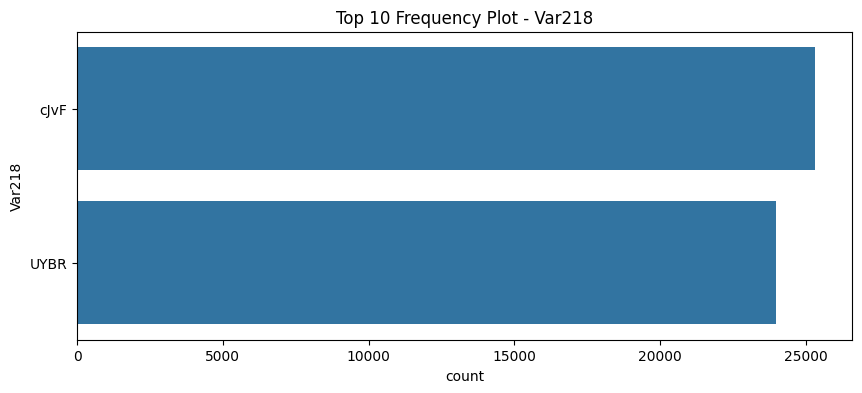

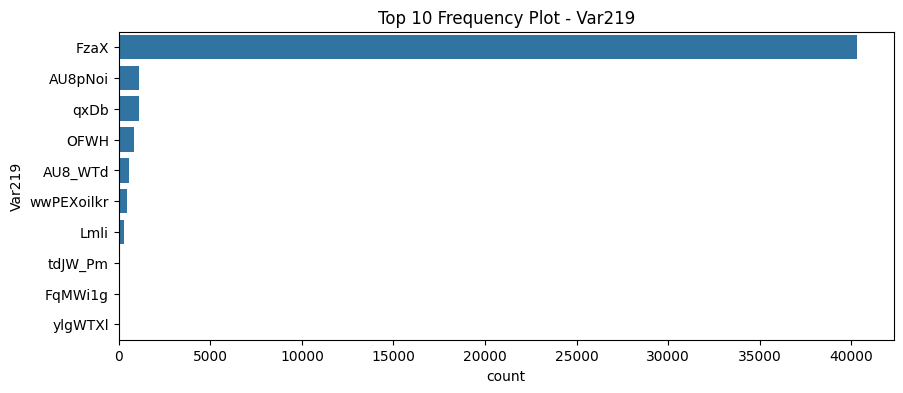

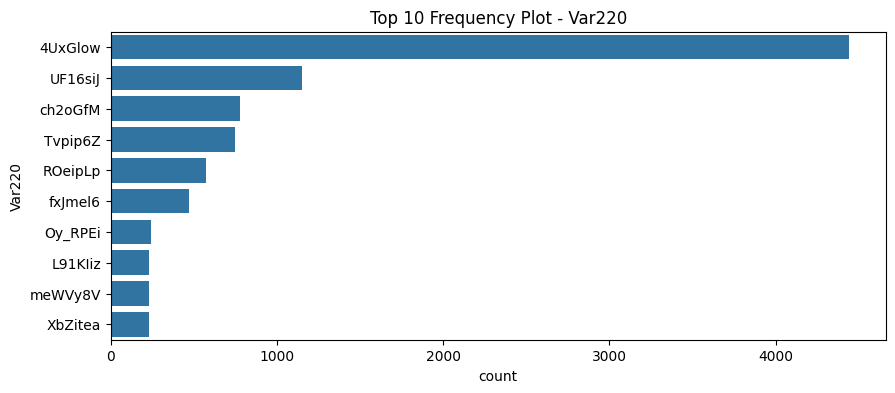

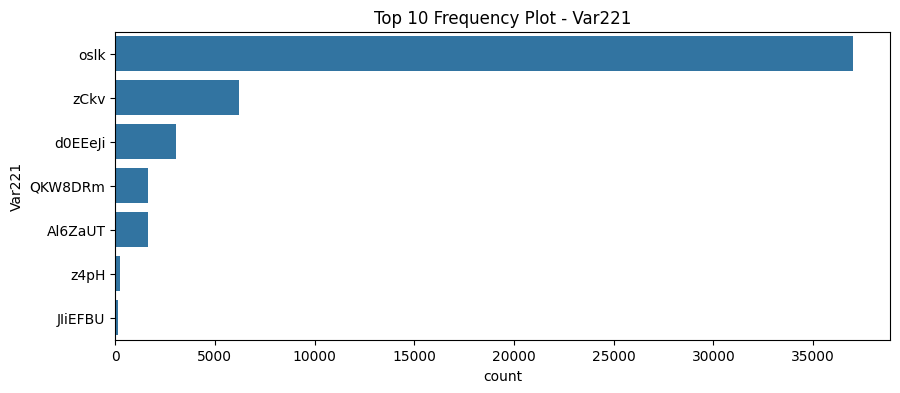

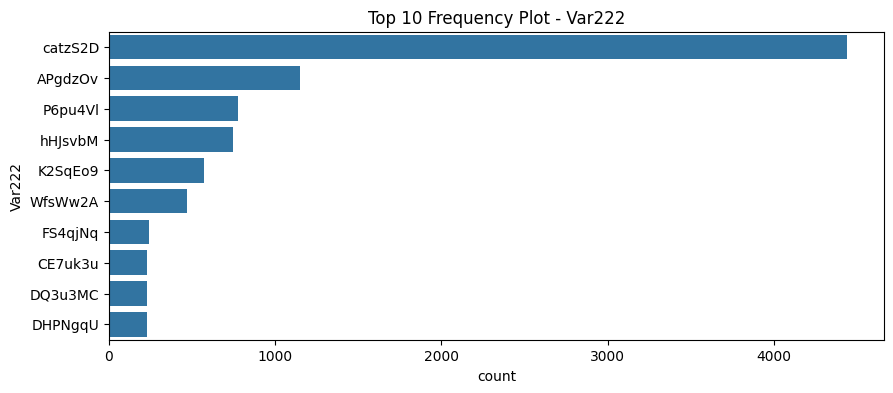

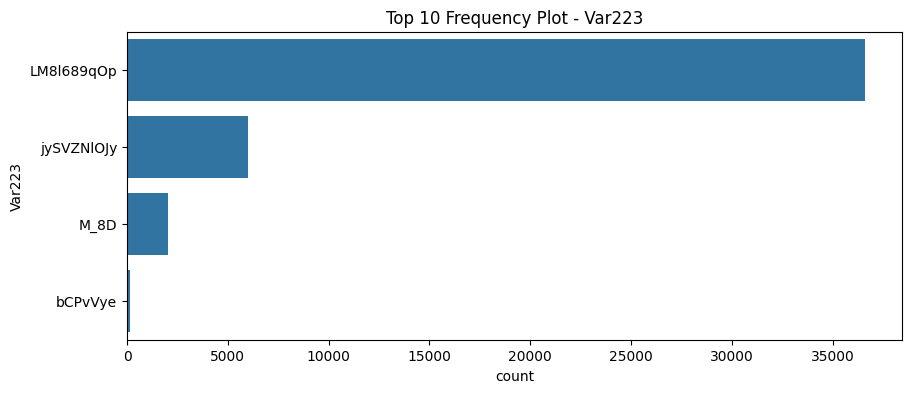

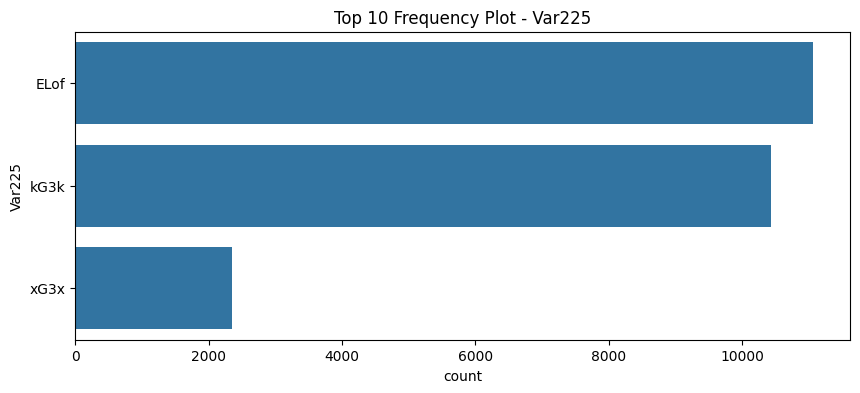

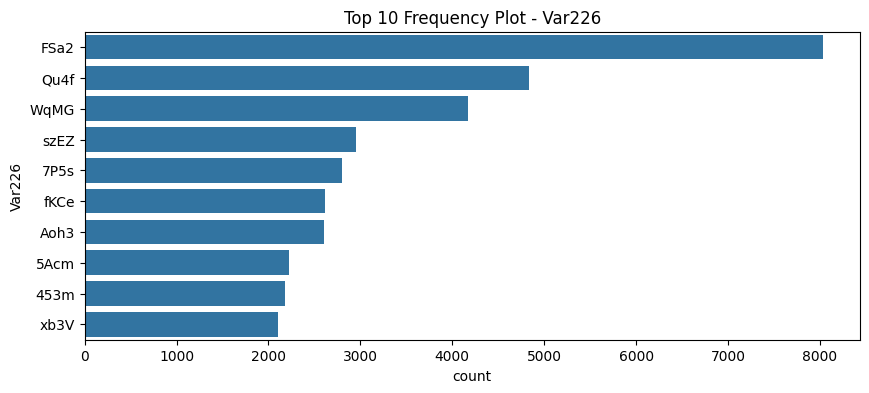

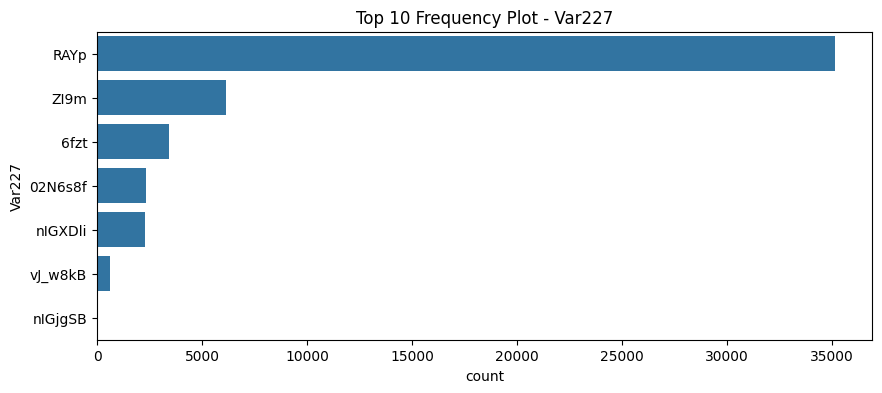

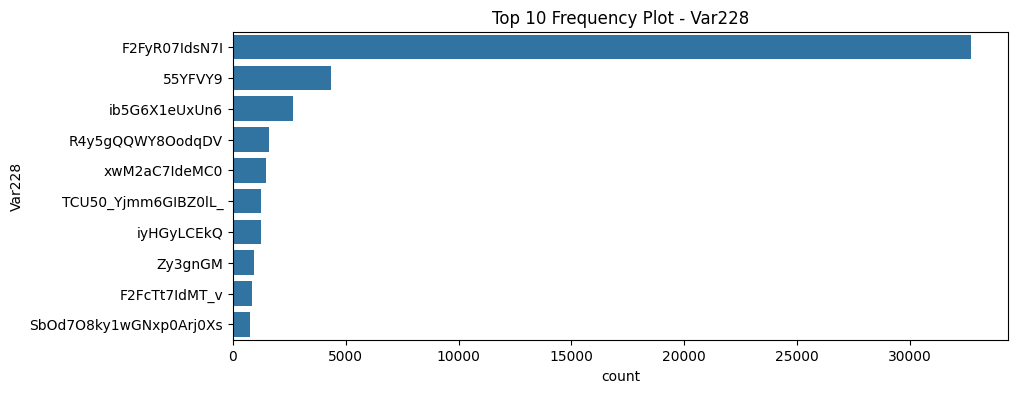

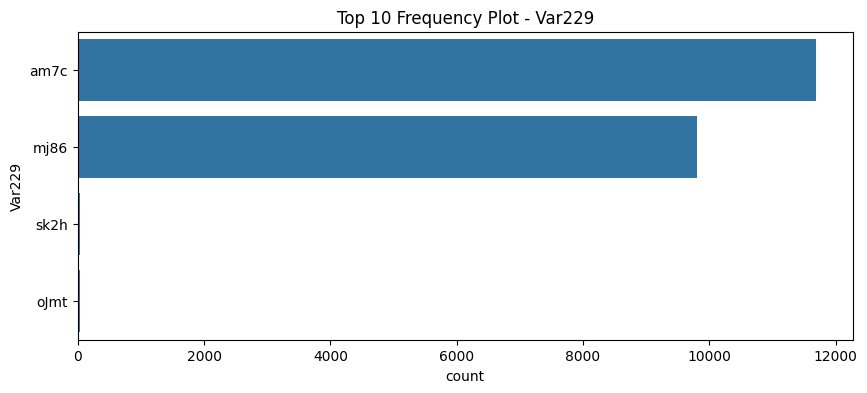

In [58]:



numeric_summary = X[numeric_cols].describe().T
print("Numeric Summary:\n", numeric_summary)

# Histograms
X[numeric_cols].hist(figsize=(20, 15), bins=30)
plt.suptitle("Histograms of Numeric Features")
plt.show()

# --- Categorical Statistical Summary ---
for col in categorical_cols:
    print(f"\n{col} - Cardinality: {X[col].nunique()}")
    print(X[col].value_counts().head(10))

# Frequency plots
for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(y=col, data=X, order=X[col].value_counts().index[:10])
    plt.title(f"Top 10 Frequency Plot - {col}")
    plt.show()

In [59]:

for col in numeric_cols:
    q1 = X[col].quantile(0.25)
    q3 = X[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    X[col] = np.where(X[col] < lower, lower, np.where(X[col] > upper, upper, X[col]))

In [ ]:
# from scipy.stats import zscore

# # Z-score calculation
# z_scores = np.abs(zscore(X[numeric_cols]))
# outliers_z = (z_scores > 3)

# # Count of outliers per column
# outlier_counts = pd.Series(np.sum(outliers_z, axis=0), index=numeric_cols)
# print("Outliers detected per column using Z-score:\n", outlier_counts.sort_values(ascending=False).head(10))

Outliers detected per column using Z-score:
 Var6      0
Var134    0
Var112    0
Var113    0
Var119    0
Var123    0
Var125    0
Var126    0
Var132    0
Var133    0
dtype: int64


In [ ]:
num_imputer = SimpleImputer(strategy="median")
X[numeric_cols] = num_imputer.fit_transform(X[numeric_cols])

cat_cols = X.select_dtypes(include="object").columns
cat_imputer = SimpleImputer(strategy="constant")
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

In [62]:
X.columns

Index(['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25', 'Var28',
       'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var72', 'Var73', 'Var74',
       'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var94', 'Var109',
       'Var112', 'Var113', 'Var119', 'Var123', 'Var125', 'Var126', 'Var132',
       'Var133', 'Var134', 'Var140', 'Var143', 'Var144', 'Var149', 'Var153',
       'Var160', 'Var163', 'Var173', 'Var181', 'Var189', 'Var192', 'Var193',
       'Var194', 'Var195', 'Var196', 'Var197', 'Var198', 'Var199', 'Var200',
       'Var201', 'Var202', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207',
       'Var208', 'Var210', 'Var211', 'Var212', 'Var214', 'Var216', 'Var217',
       'Var218', 'Var219', 'Var220', 'Var221', 'Var222', 'Var223', 'Var225',
       'Var226', 'Var227', 'Var228', 'Var229'],
      dtype='object')

In [ ]:
df = pd.concat([X,y],axis = 1)

In [64]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [68]:
from category_encoders import TargetEncoder

# high_card_cat_cols = []  # Replace with actual high-cardinality feature names
low_cardinality_cols = [col for col in cat_cols if df[col].nunique() <= 10]
high_cardinality_cols = [col for col in cat_cols if df[col].nunique() > 10]

print("Low Cardinality Columns:", low_cardinality_cols)
print("High Cardinality Columns:", high_cardinality_cols)

# One-Hot Encode Low Cardinality Columns
if low_cardinality_cols:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    ohe_encoded = pd.DataFrame(ohe.fit_transform(df[low_cardinality_cols]),
                                columns=ohe.get_feature_names_out(low_cardinality_cols),
                                index=df.index)
    df = pd.concat([df.drop(columns=low_cardinality_cols), ohe_encoded], axis=1)

# Target Encode High Cardinality Columns
if high_cardinality_cols:
    te = TargetEncoder(cols=high_cardinality_cols)
    df[high_cardinality_cols] = te.fit_transform(df[high_cardinality_cols], y)

Low Cardinality Columns: ['Var194', 'Var196', 'Var201', 'Var203', 'Var205', 'Var208', 'Var210', 'Var211', 'Var218', 'Var221', 'Var223', 'Var225', 'Var227', 'Var229']
High Cardinality Columns: ['Var192', 'Var193', 'Var195', 'Var197', 'Var198', 'Var199', 'Var200', 'Var202', 'Var204', 'Var206', 'Var207', 'Var212', 'Var214', 'Var216', 'Var217', 'Var219', 'Var220', 'Var222', 'Var226', 'Var228']


In [69]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = df.drop('Label', axis=1)
y = df['Label']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)



In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=0.95, random_state=42)
# X_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var227_RAYp,Var227_ZI9m,Var227_nIGXDli,Var227_nIGjgSB,Var227_vJ_w8kB,Var229_am7c,Var229_missing_value,Var229_mj86,Var229_oJmt,Var229_sk2h
15257,0.433827,0.110940,2.129993,-0.101693,-0.093093,0.143850,-0.135249,0.628915,0.0,0.937920,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8643,-1.265753,-1.328719,-0.689677,-0.396830,-0.381788,-0.836256,0.079828,0.672611,0.0,1.059307,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
45255,-0.336149,0.110940,-0.326252,0.931286,0.917339,-0.346203,0.402443,-0.284335,0.0,0.605598,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
33083,2.349376,0.110940,-0.583156,1.742913,1.711250,2.104064,0.725059,0.903109,0.0,1.890055,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14813,-0.373709,0.110940,-0.523629,-0.396830,-0.381788,-0.346203,-0.350326,-0.740960,0.0,0.156268,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40302,-0.336149,0.110940,0.529047,-0.359938,-0.345701,-0.836256,-0.780480,0.684628,0.0,-0.226305,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19457,-0.345539,0.110940,2.451122,-0.691967,-0.670483,-0.836256,-0.888018,-2.102097,0.0,-0.846265,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6467,-1.106124,-1.328719,-0.689677,-1.282240,-1.247873,-0.836256,-0.780480,0.772020,0.0,0.471774,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6131,0.105179,0.110940,1.290358,0.082768,0.087341,0.633904,-0.135249,1.656868,0.0,-0.855533,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Only use numeric features (after encoding & scaling)
X_vif = X_train.copy()

# Add constant for intercept
X_vif_const = add_constant(X_vif)

# Calculate VIF
vif_df = pd.DataFrame()
vif_df["feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif_const.values, i+1)  # +1 to skip the constant
                 for i in range(X_vif.shape[1])]

# Display high-VIF features
print(vif_df.sort_values(by="VIF", ascending=False))

# Optionally drop those > 10
high_vif_features = vif_df[vif_df["VIF"] > 10]["feature"]
X_train.drop(columns=high_vif_features, inplace=True)
X_test.drop(columns=high_vif_features, inplace=True)

/opt/anaconda3/envs/llm/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/anaconda3/envs/llm/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


            feature           VIF
78      Var203_pybr           inf
68      Var196_mKeq           inf
123     Var229_oJmt  4.112876e+13
106  Var223_bCPvVye  8.813307e+12
76      Var203_dgxZ  7.711643e+12
..              ...           ...
17            Var78           NaN
29           Var132           NaN
33           Var143           NaN
39           Var173           NaN
40           Var181           NaN

[125 rows x 2 columns]


In [78]:
# SMOTE Oversampling
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    'Logistic Regression (L1)': LogisticRegression(penalty='l1', solver='liblinear'),
    'Logistic Regression (L2)': LogisticRegression(penalty='l2'),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced'),
    'XGBoost': XGBClassifier(eval_metric='logloss', class_weight = 'balanced')
}

for name, model in models.items():
    if name == "XGBoost":
        y_train = y_train.replace(-1, 0)

    model.fit(X_train, y_train)
    print(f"{name} - Training Done")


/opt/anaconda3/envs/llm/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Logistic Regression (L1) - Training Done


/opt/anaconda3/envs/llm/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression (L2) - Training Done
Random Forest - Training Done


/opt/anaconda3/envs/llm/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:56:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost - Training Done



Logistic Regression (L1)
              precision    recall  f1-score   support

          -1       0.98      0.84      0.91      9266
           1       0.28      0.77      0.41       734

    accuracy                           0.84     10000
   macro avg       0.63      0.81      0.66     10000
weighted avg       0.93      0.84      0.87     10000

Confusion Matrix:
 [[7804 1462]
 [ 166  568]]
ROC AUC Score: 0.8903800540018857
PR - AUC score: 0.38229197097475986

Logistic Regression (L2)
              precision    recall  f1-score   support

          -1       0.98      0.85      0.91      9266
           1       0.28      0.76      0.41       734

    accuracy                           0.84     10000
   macro avg       0.63      0.81      0.66     10000
weighted avg       0.93      0.84      0.87     10000

Confusion Matrix:
 [[7837 1429]
 [ 173  561]]
ROC AUC Score: 0.8901271590903075
PR - AUC score: 0.37671219285635654

Random Forest
              precision    recall  f1-score   s

<Figure size 640x480 with 0 Axes>

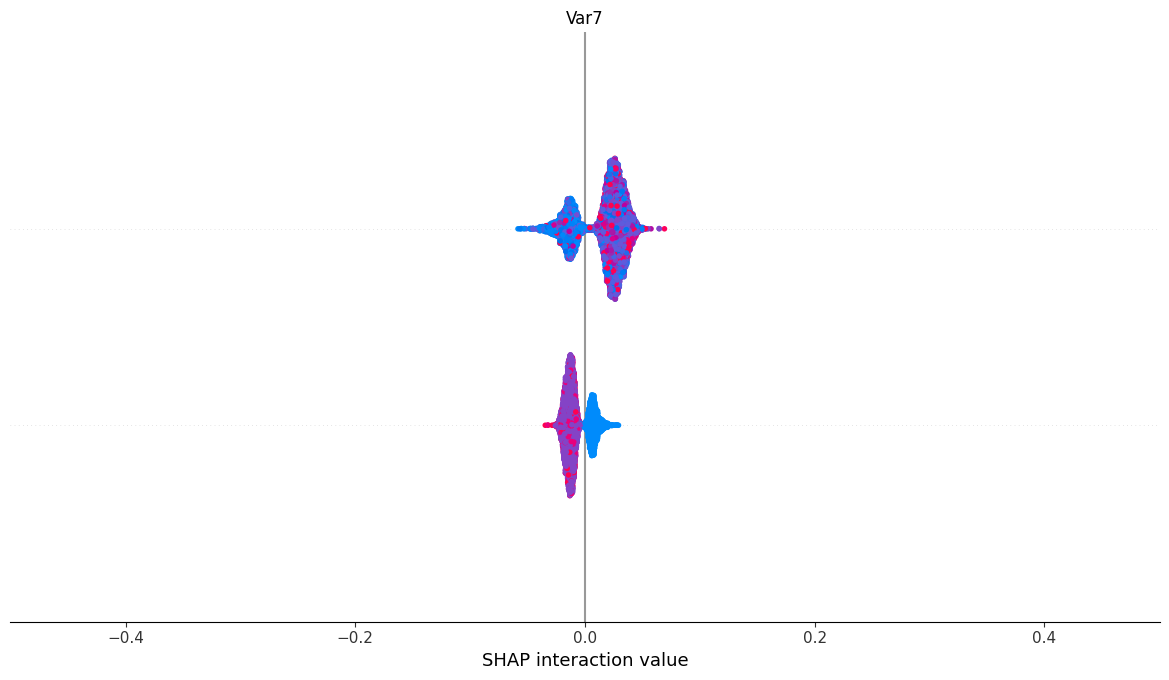


XGBoost
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      9266
           1       0.58      0.43      0.50       734

    accuracy                           0.94     10000
   macro avg       0.77      0.70      0.73     10000
weighted avg       0.93      0.94      0.93     10000

Confusion Matrix:
 [[9038  228]
 [ 417  317]]
ROC AUC Score: 0.9160912327215434
PR - AUC score: 0.5764814393193971


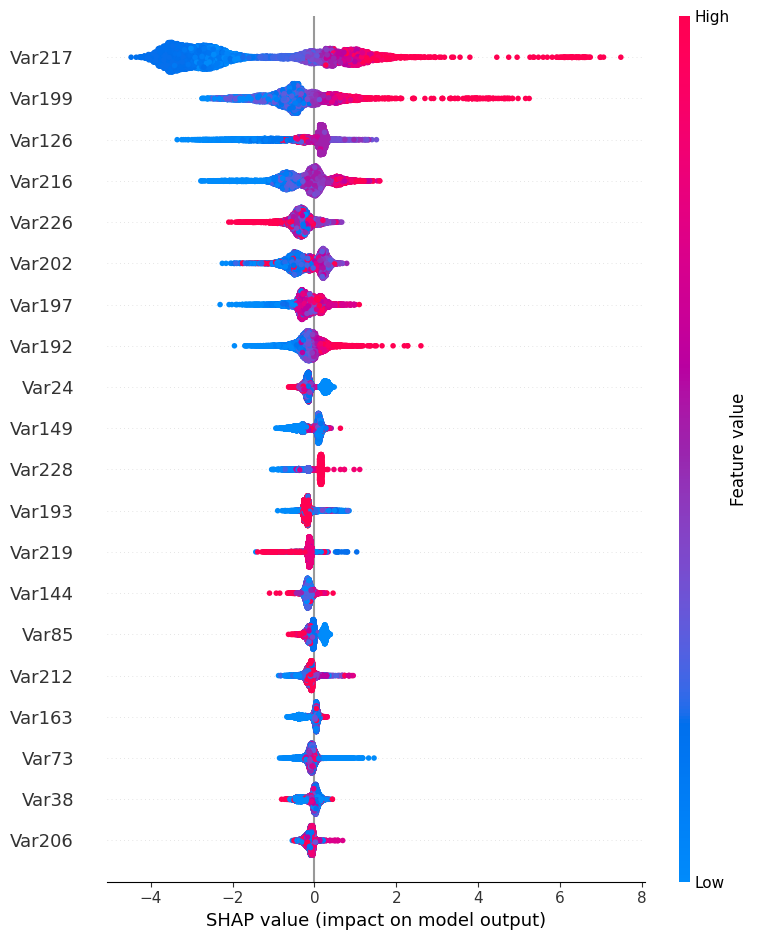

In [85]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,average_precision_score
import shap

for name, model in models.items():
    if name == "XGBoost":
        y_test = y_test.replace(-1, 0)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"\n{name}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
    print("PR - AUC score:",average_precision_score(y_test, y_proba))
    
    if name.startswith("Logistic Regression"): continue
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test)


In [ ]:
y